# Running pyBOA on SST

In [32]:
# imports
import os

import numpy as np
import h5py
import xarray

from matplotlib import pyplot as plt

from wrangler.plotting import cutout

from fronts.pyboa import pyBOA

# Load up training data

In [46]:
## B = Inputs = Div SST, SSS, SST 
        #   Targets = Divb2 

In [47]:
b_file = os.path.join(os.getenv('OS_OGCM'), 'LLC', 'Fronts', 'Training_Sets', 
                     'LLC4320_SST144_SSS40_trainB.h5')

In [48]:
b_train = h5py.File(b_file, 'r')
b_train.keys()

<KeysViewHDF5 ['inputs', 'targets']>

In [49]:
b_train['inputs'].shape,  b_train['targets'].shape

((1000, 3, 1, 64, 64), (1000, 1, 1, 64, 64))

In [55]:
def parse_idx(idx):
    # Parase
    div_sst = b_train['inputs'][idx, 0, 0, ...]
    sst = b_train['inputs'][idx, 2, 0, ...]
    sss = b_train['inputs'][idx, 1, 0, ...]
    #
    Divb2 = b_train['targets'][idx, 0, 0, ...]
    #
    return div_sst, sst, sss, Divb2

In [51]:
def plot_example(idx):
    div_sst, sst, sss, Divb2 = parse_idx(idx)

    # Plot
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
    cutout.show_image(sst, clbl='SST (deg C)', ax=ax1)
    cutout.show_image(div_sst, clbl=r'|Div SST|$^2$', cm='viridis', ax=ax2)
    #cutout.show_image(sss, clbl='SSS (psu)', cm='viridis', ax=ax2)
    cutout.show_image(Divb2, clbl=r'$\nabla b^2$', cm='Greys', ax=ax3)
    #
    plt.show()

In [52]:
def arr_to_dataset(arr):
    ds = xarray.Dataset({
    'data': (['x', 'y'], arr)}, coords={
    'x': range(arr.shape[0]),  # 0, 1, 2, ..., 9
    'y': range(arr.shape[1]),  # 0, 1, 2, 3, 4
    })
    return ds

# Try it

## Pick one

In [56]:
idx = 500
div_sst, sst, sss, Divb2 = parse_idx(idx)

### Plot it

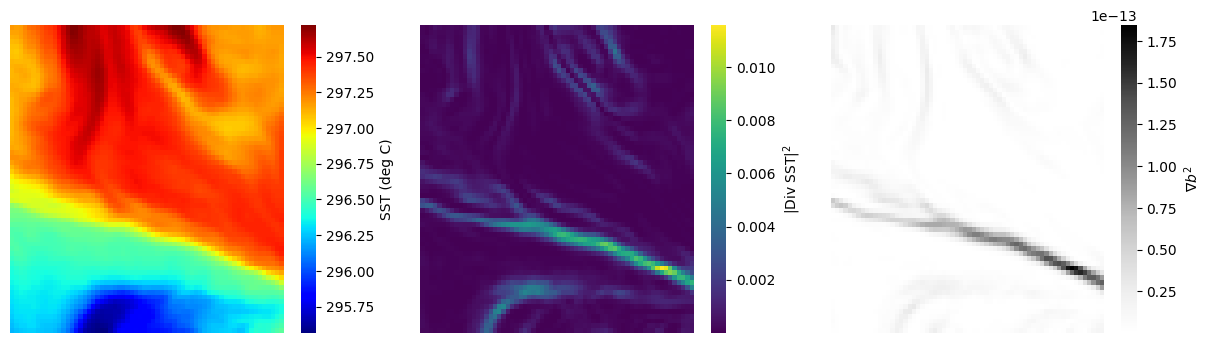

In [9]:
plot_example(idx)

## PyBOA

## Recast SST as xarray.DataArray

In [27]:
sst_ds = arr_to_dataset(sst)
sst_ds

<xarray.Dataset> Size: 17kB
Dimensions:  (x: 64, y: 64)
Coordinates:
  * x        (x) int64 512B 0 1 2 3 4 5 6 7 8 9 ... 55 56 57 58 59 60 61 62 63
  * y        (y) int64 512B 0 1 2 3 4 5 6 7 8 9 ... 55 56 57 58 59 60 61 62 63
Data variables:
    data     (x, y) float32 16kB 296.2 296.2 296.3 296.3 ... 297.2 297.2 297.2

In [20]:
## Instantiate and run

In [28]:
pyboa = pyBOA.pyBOA(sst_ds)

In [29]:
boa = pyboa.auto_detection()

In [30]:
boa

<xarray.DataArray 'data' (time: 1, latitude: 64, longitude: 64)> Size: 16kB
array([[[296.21655, 296.24426, 296.26398, ..., 296.47607, 296.5224 ,
         296.5517 ],
        [296.2336 , 296.26648, 296.28214, ..., 296.44553, 296.48248,
         296.50894],
        [296.2511 , 296.28372, 296.29364, ..., 296.4058 , 296.43698,
         296.46982],
        ...,
        [297.12698, 297.13892, 297.1632 , ..., 297.16132, 297.16254,
         297.16275],
        [297.15308, 297.15448, 297.17242, ..., 297.1665 , 297.1678 ,
         297.16855],
        [297.17526, 297.1622 , 297.17087, ..., 297.17502, 297.17755,
         297.18167]]], shape=(1, 64, 64), dtype=float32)
Coordinates:
  * latitude       (latitude) int64 512B 0 1 2 3 4 5 6 ... 57 58 59 60 61 62 63
  * longitude      (longitude) int64 512B 0 1 2 3 4 5 6 ... 57 58 59 60 61 62 63
    data_filtered  (time, latitude, longitude) float32 16kB 296.2 ... 297.2
    data_sobel     (time, latitude, longitude) float64 33kB 0.5491 ... 0.09235
    data_fronts    (time, latitude, longitude) float64 33kB nan nan ... nan nan
Dimensions without coordinates: time

In [33]:
np.sum(np.isfinite(boa.data_fronts))

<xarray.DataArray 'data_fronts' ()> Size: 8B
array(98)

## Plot em

In [69]:
def plot_fronts(idx, boa):
    div_sst, sst, sss, Divb2 = parse_idx(idx)

    # Plot
    fig = plt.figure(figsize=(5,5))
    ax = plt.gca()
    #
    cutout.show_image(np.flipud(Divb2), cbar=False, #clbl=r'$\nabla b^2$', 
                      cm='Greys', ax=ax)
    # BOA
    col,row = np.where(np.isfinite(boa.data_fronts.isel(time=0).data))
    ax.scatter(row, col, s=1.0, color='red')
    #
    plt.show()

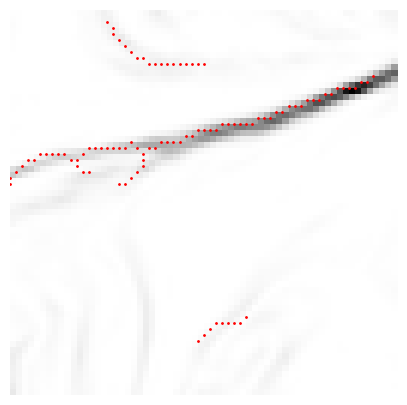

In [70]:
plot_fronts(idx, boa)